In [1]:
import sys
sys.path.append("/tf/easl-eye")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

## Local Package
import easl_eye as eye
from easl_eye.io import *
from easl_eye.preprocess import eyes as blink

In [3]:
# Loading the two different datasets
image_tracking = get_viewer_tracking_info(url="http://amc-tensor1.ucdenver.pvt/eyetracking")
eye_tracking = load_eyetracking_data(fname="/tf/eye-tracking/test_gaze_data.csv")

In [4]:
eye_tracking = blink.format_data(eye_tracking, 
                                 screen_size=(59.789,33.631), # cm
                                 screen_res=(2560,1440), # px
                                 viewing_dist=82) # cm

In [5]:
right_gaze = blink.classify(eye_tracking, 'right')
left_gaze = blink.classify(eye_tracking, 'left')

/usr/local/lib/python3.8/dist-packages/cateyes/utils.py:365: UserWarning: 

Irregular sampling rate detected. This can lead to impaired performance with this classifier. Consider resampling your data to a fixed sampling rate. Setting sampling rate to average sample difference.
  warnings.warn(WARN_SFREQ)


In [6]:
right_gaze

,timestamp_hardware,timestamp_in_seconds,segment_id,segment_class
0,415541834440,1.662167e+09,0,Fixation
1,415541842774,1.662167e+09,0,Fixation
2,415541851107,1.662167e+09,0,Fixation
3,415541859440,1.662167e+09,0,Fixation
4,415541867773,1.662167e+09,0,Fixation
...,...,...,...,...
9031,415617095119,1.662468e+09,614,Fixation
9032,415617103452,1.662468e+09,614,Fixation
9033,415617111794,1.662468e+09,614,Fixation
9034,415617120127,1.662468e+09,614,Fixation


In [7]:
right_gaze.segment_class.unique()

array(['Fixation', 'Saccade'], dtype=object)

In [10]:
from cateyes import plot_segmentation, continuous_to_discrete

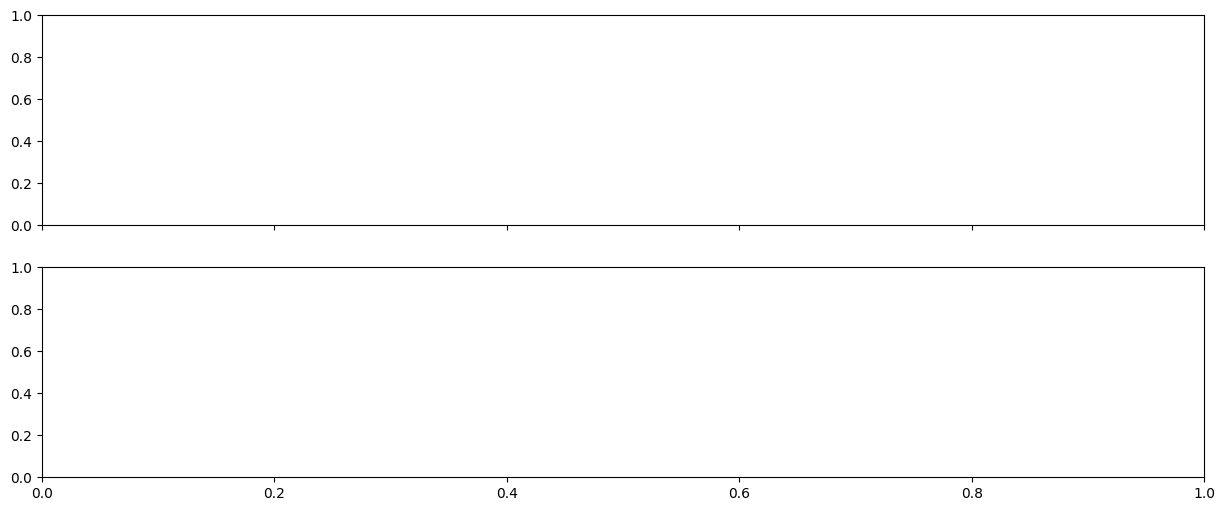

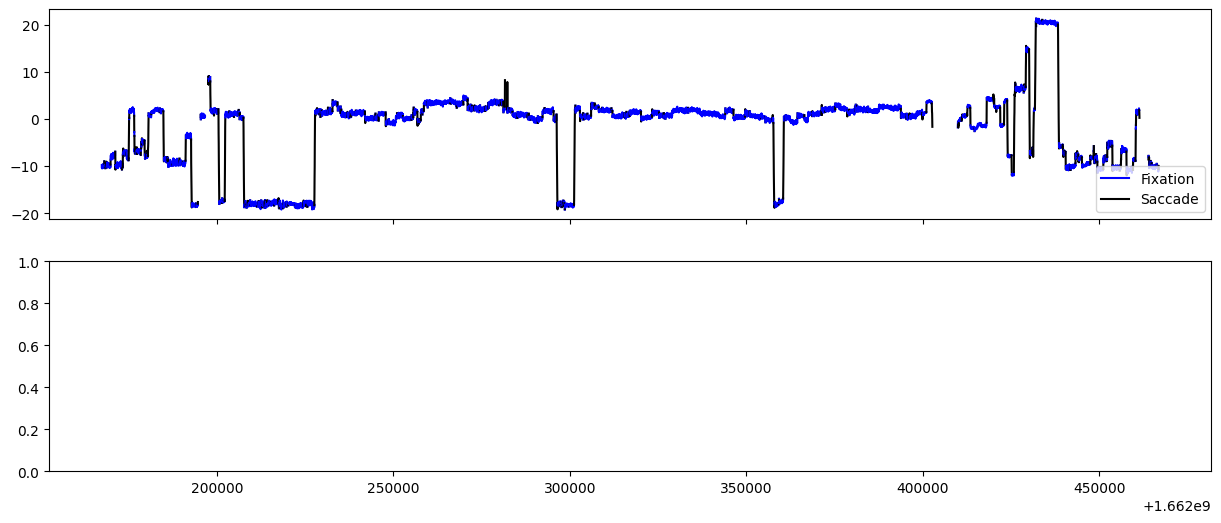

In [12]:
# convert continuous ids and descriptions to discrete timepoints and descriptions
(seg_time, seg_class) = continuous_to_discrete(right_gaze['timestamp_in_seconds'], right_gaze['segment_id'], right_gaze['segment_class'])

# plot the classification results
fig, axes = plt.subplots(2, figsize=(15, 6), sharex=True)
plot_segmentation(
    eye_tracking['right_x_deg'], 
    times=right_gaze['timestamp_in_seconds'],
    segments=(seg_time, seg_class),
    events=None, ax=axes[0])
plot_segmentation(
    eye_tracking['right_y_deg'], 
    times=right_gaze['timestamp_in_seconds'],
    segments=(seg_time, seg_class),
    events=None, ax=axes[0])
# plot_segmentation(y_deg, times, segments=(seg_time, seg_class), events=None, ax=axes[1],
#                   show_legend=False);

plt.show()

In [8]:
res[0]

2560

In [15]:
eye_tracking['right_x'].apply(lambda x: float(x) * res[0])

0       674.068909
1       632.355118
2       676.840897
3       629.970245
4       665.489883
           ...    
9031    623.856201
9032    654.365997
9033    656.839066
9034    647.413864
9035    650.187378
Name: right_x, Length: 9036, dtype: float64

In [13]:
res[0]

2560

In [14]:
eye_tracking['right_x'][0]

'0.26330816745758057'